In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, chi2_contingency


## Go to the /users/pgrad/mamu/Documents/first/ directory 


In [5]:
# Go to the /users/pgrad/mamu/Documents/first/ directory 
import os
os.chdir('/users/pgrad/mamu/Documents/first/')

## Load datasets


In [6]:
# Load datasets
original_data = pd.read_csv('./datasets/data.csv')
generated_data_llama3 = pd.read_csv('./llama3-8b/results/synthetic_data_llama_3_8b.csv')
generated_data_mistral = pd.read_csv('./mistral-7b/results/synthetic_data_mistral-7b.csv')
generated_data_ctgan = pd.read_csv('./ctgan/results/synthetic_data_ctgan.csv')
generated_data_begreat = pd.read_csv('./begreat/results/synthetic_data_begreat.csv')

## Feature Engineering

In [7]:
# Print the length of the datasets
print('Original data length:', len(original_data))
print('LLAMA-3 length:', len(generated_data_llama3))
print('Mistral length:', len(generated_data_mistral))
print('CTGAN length:', len(generated_data_ctgan))
print('BeGreat length:', len(generated_data_begreat))

# Subset the datasets to the minimum length
min_length = min(len(original_data), len(generated_data_llama3), len(generated_data_mistral), len(generated_data_ctgan), len(generated_data_begreat))
original_data = original_data.sample(min_length)
generated_data_llama3 = generated_data_llama3.sample(min_length)
generated_data_mistral = generated_data_mistral.sample(min_length)
generated_data_ctgan = generated_data_ctgan.sample(min_length)
generated_data_begreat = generated_data_begreat.sample(min_length)


Original data length: 349
LLAMA-3 length: 1580
Mistral length: 672
CTGAN length: 1000
BeGreat length: 300


In [8]:
# List of possible values for the categorical column ' Disease' from both datasets
original_disease_values = original_data['Disease'].unique()
generated_disease_values_llama3 = generated_data_llama3['Disease'].unique()
generated_disease_values_mistral = generated_data_mistral['Disease'].unique()
generated_disease_values_ctgan = generated_data_ctgan['Disease'].unique()
generated_disease_values_begreat = generated_data_begreat['Disease'].unique()


# Print the list of possible values for the categorical column ' Disease' from both datasets
print('Original Disease Values:', original_disease_values)
print('LLAMA-3 Disease Values:', generated_disease_values_llama3)
print('Mistral Disease Values:', generated_disease_values_mistral)
print('CTGAN Disease Values:', generated_disease_values_ctgan)
print('BeGreat Disease Values:', generated_disease_values_begreat)


Original Disease Values: ['Muscular Dystrophy' 'Coronary Artery Disease' 'Stroke' 'Osteoarthritis'
 'Kidney Cancer' 'Hyperthyroidism' 'Kidney Disease'
 'Pneumocystis Pneumonia (PCP)' 'Tuberculosis' 'Gastroenteritis'
 'Pneumonia' 'Osteoporosis' 'Diverticulitis' 'Hemophilia'
 'Bipolar Disorder' 'Migraine' 'Allergic Rhinitis' 'Anxiety Disorders'
 'Ovarian Cancer' "Crohn's Disease" 'Hypertension' 'Glaucoma'
 "Alzheimer's Disease" 'Measles' 'Psoriasis' 'Liver Disease' 'Cirrhosis'
 'Diabetes' 'Hypothyroidism' 'Bronchitis' 'Depression' 'Liver Cancer'
 'Asthma' 'Multiple Sclerosis' 'Zika Virus' 'Rheumatoid Arthritis'
 'Influenza' 'Mumps' 'Prostate Cancer' 'Malaria' 'Thyroid Cancer'
 'Turner Syndrome' 'Cholecystitis'
 'Chronic Obstructive Pulmonary Disease (COPD)' 'Cholera' 'Breast Cancer'
 'Brain Tumor' "Parkinson's Disease" 'Lung Cancer' 'Pancreatitis'
 'Atherosclerosis' 'Hepatitis B' 'Common Cold' 'Tourette Syndrome'
 'Epilepsy' 'Marfan Syndrome' 'Polio' 'Otitis Media (Ear Infection)'
 'Obse

In [9]:
# Define the upper categories
categories = {
    "Respiratory Diseases": [
        'Influenza', 'Common Cold', 'Asthma', 'Allergic Rhinitis', 'Tuberculosis',
        'Sinusitis', 'Bronchitis', 'Pneumonia', 'Chronic Obstructive Pulmonary Disease',
        'Laryngitis', 'Pneumothorax'
    ],
    "Skin Diseases": ['Eczema', 'Psoriasis', 'Acne'],
    "Endocrine and Metabolic Diseases": [
        'Hyperthyroidism', 'Hypothyroidism', 'Diabetes', 'Hyperglycemia', 'Hypoglycemia'
    ],
    "Mental and Behavioral Disorders": [
        'Anxiety Disorders', 'Depression', 'Bipolar Disorder', 'Obsessive-Compulsive Disorder',
        'Autism Spectrum Disorder (ASD)', 'Schizophrenia', 'Eating Disorders (Anorexia, etc.)', 'Dementia'
    ],
    "Cardiovascular Diseases": [
        'Hypertensive Heart Disease', 'Myocardial Infarction (Heart Attack)', 'Coronary Artery Disease',
        'Atherosclerosis', 'Hypertension', 'Stroke'
    ],
    "Gastrointestinal Diseases": [
        'Gastroenteritis', 'Pancreatitis', 'Hepatitis', 'Cirrhosis', 'Ulcerative Colitis', 'Crohn\'s Disease',
        'Irritable Bowel Syndrome', 'Appendicitis', 'Diverticulitis', 'Cholecystitis'
    ],
    "Cancers": [
        'Liver Cancer', 'Kidney Cancer', 'Colorectal Cancer', 'Lung Cancer', 'Brain Tumor', 'Ovarian Cancer',
        'Pancreatic Cancer', 'Esophageal Cancer', 'Prostate Cancer', 'Testicular Cancer', 'Bladder Cancer',
        'Thyroid Cancer', 'Melanoma', 'Lymphoma', 'Breast Cancer'
    ],
    "Neurological Disorders": [
        'Migraine', 'Multiple Sclerosis', 'Epilepsy', 'Cerebral Palsy', 'Parkinson\'s Disease', 'Alzheimer\'s Disease',
        'Spina Bifida', 'Tourette Syndrome'
    ],
    "Musculoskeletal Diseases": [
        'Rheumatoid Arthritis', 'Osteoarthritis', 'Osteoporosis', 'Muscular Dystrophy', 'Fibromyalgia', 'Scoliosis',
        'Gout', 'Osteomyelitis'
    ],
    "Infectious Diseases": [
        'Dengue Fever', 'Rabies', 'Chickenpox', 'Rubella', 'Malaria', 'Zika Virus', 'Tetanus', 'Cholera', 'Sepsis',
        'Ebola Virus', 'Lyme Disease', 'Measles', 'Mumps', 'Typhoid Fever'
    ],
    "Urinary and Reproductive Diseases": [
        'Urinary Tract Infection (UTI)', 'Polycystic Ovary Syndrome (PCOS)', 'Endometriosis', 'Kidney Disease',
        'Chronic Kidney Disease'
    ],
    "Blood Disorders": [
        'Anemia', 'Sickle Cell Anemia', 'Hemophilia'
    ],
    "Genetic Disorders": [
        'Down Syndrome', 'Klinefelter Syndrome', 'Turner Syndrome', 'Marfan Syndrome', 'Prader-Willi Syndrome', 'Williams Syndrome'
    ],
    "Miscellaneous": [
        'Conjunctivitis (Pink Eye)', 'Glaucoma', 'Cataracts', 'Sinusitis', 'Epilepsy', 'Hemorrhoids', 'Sleep Apnea'
    ]
}

# Initialize the category counts
categories_count = {
    "Respiratory Diseases": 0,
    "Skin Diseases": 0,
    "Endocrine and Metabolic Diseases": 0,
    "Mental and Behavioral Disorders": 0,
    "Cardiovascular Diseases": 0,
    "Gastrointestinal Diseases": 0,
    "Cancers": 0,
    "Neurological Disorders": 0,
    "Musculoskeletal Diseases": 0,
    "Infectious Diseases": 0,
    "Urinary and Reproductive Diseases": 0,
    "Blood Disorders": 0,
    "Genetic Disorders": 0,
    "Miscellaneous": 0
}

# Function to classify diseases into categories and update counts
def classify_disease(disease):
    for category, diseases in categories.items():
        if disease in diseases:
            categories_count[category] += 1
            return category
    return 'Miscellaneous'


## Descriptive statistics comparison


#### Check if some of the diseases are new in the generated dataset


In [11]:
# Check if some of the diseases are new in the generated dataset
new_diseases_llama3 = [disease for disease in generated_disease_values_llama3 if disease not in original_disease_values]
print(f'New diseases in LLAMA-3: {new_diseases_llama3} \n')

new_diseases_mistral = [disease for disease in generated_disease_values_mistral if disease not in original_disease_values]
print(f'New diseases in Mistral: {new_diseases_mistral} \n')

new_diseases_ctgan = [disease for disease in generated_disease_values_ctgan if disease not in original_disease_values]
print(f'New diseases in CTGAN: {new_diseases_ctgan} \n')

new_diseases_begreat = [disease for disease in generated_disease_values_begreat if disease not in original_disease_values]
print(f'New diseases in BeGreat: {new_diseases_begreat} \n')

New diseases in LLAMA-3: ['Laryngitis', 'Thyroiditis', 'Menopause', 'Chronic Obstructive Pulmonary Disease', 'Pulmonary Embolism', 'Pseudomonas Pneumonia', 'Dermatitis', 'Bronchiectasis', "Sjogren's Syndrome", 'Gastroesophageal Reflux Disease', 'Zollinger-Ellison Syndrome', 'Yellow Fever', 'Chronic Bronchitis', 'Pseudotumor Cerebri', 'Irritable Bowel Syndrome', 'Meningitis', 'Lymphangioleiomyomatosis', 'Multiple Chemical Sensitivity', 'Interstitial Cystitis', 'Polycystic Kidney Disease', 'Sarcoidosis', 'SARS-CoV-2', 'Hypersensitivity Pneumonitis', 'Myasthenia Gravis', 'Rheumatic Fever', 'Pleurisy', 'Gastroesophageal Reflux Disease (GERD)', 'Kidney Failure', 'Pulmonary Hypertension', 'Lupus', 'Q Fever', 'Idiopathic Pulmonary Fibrosis', 'Ulcerative Keratitis', 'Cellulitis', 'Hypocalcemia', 'Tularemia', "Raynaud's Disease", 'Diabetes Mellitus', 'Hypertensive Crisis', 'Churg-Strauss Syndrome', 'Pneumopericardium', 'Chronic Pancreatitis', 'Kidney Stones', "Bell's Palsy", 'MERS-CoV', 'Irrita

In [12]:
# Create a new column 'Disease Category' in both datasets
original_data['Disease Category'] = original_data['Disease'].apply(classify_disease)
generated_data_llama3['Disease Category'] = generated_data_llama3['Disease'].apply(classify_disease)
generated_data_mistral['Disease Category'] = generated_data_mistral['Disease'].apply(classify_disease)
generated_data_ctgan['Disease Category'] = generated_data_ctgan['Disease'].apply(classify_disease)
generated_data_begreat['Disease Category'] = generated_data_begreat['Disease'].apply(classify_disease)

### General description of both datasets

In [13]:
# Descriptive statistics comparison
print("Original Data Description:\n", original_data.describe())
print("Generated Data Description (LLAMA-3):\n", generated_data_llama3.describe())
print("Generated Data Description (Mistral):\n", generated_data_mistral.describe())
print("Generated Data Description (CTGAN):\n", generated_data_ctgan.describe())
print("Generated Data Description (BeGreat):\n", generated_data_begreat.describe())

# Descriptive statistics comparison for categorical columns
print("Original Data Description for Categorical Columns:\n", original_data.describe(include=['object']))
print("Generated Data Description for Categorical Columns (LLAMA-3):\n", generated_data_llama3.describe(include=['object']))
print("Generated Data Description for Categorical Columns (Mistral):\n", generated_data_mistral.describe(include=['object']))
print("Generated Data Description for Categorical Columns (CTGAN):\n", generated_data_ctgan.describe(include=['object']))
print("Generated Data Description for Categorical Columns (BeGreat):\n", generated_data_begreat.describe(include=['object']))


Original Data Description:
               Age
count  300.000000
mean    46.710000
std     13.520178
min     19.000000
25%     35.000000
50%     45.000000
75%     55.000000
max     90.000000
Generated Data Description (LLAMA-3):
               Age
count  300.000000
mean    40.680000
std     12.399061
min     17.000000
25%     30.000000
50%     40.000000
75%     50.000000
max     70.000000
Generated Data Description (Mistral):
               Age
count  300.000000
mean    34.056667
std      6.228652
min     18.000000
25%     30.000000
50%     35.000000
75%     38.000000
max     58.000000
Generated Data Description (CTGAN):
               Age
count  300.000000
mean    42.373333
std     14.418980
min     17.000000
25%     31.000000
50%     39.500000
75%     50.000000
max     83.000000
Generated Data Description (BeGreat):
               Age
count  300.000000
mean    47.536667
std     12.033481
min     25.000000
25%     40.000000
50%     45.000000
75%     55.000000
max     90.000000
Original

### Plot histograms

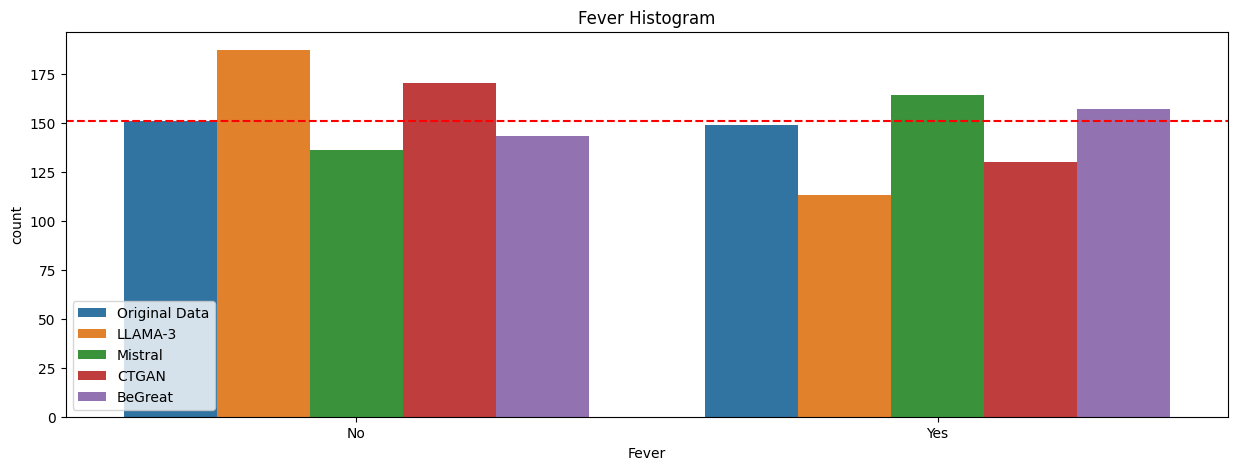

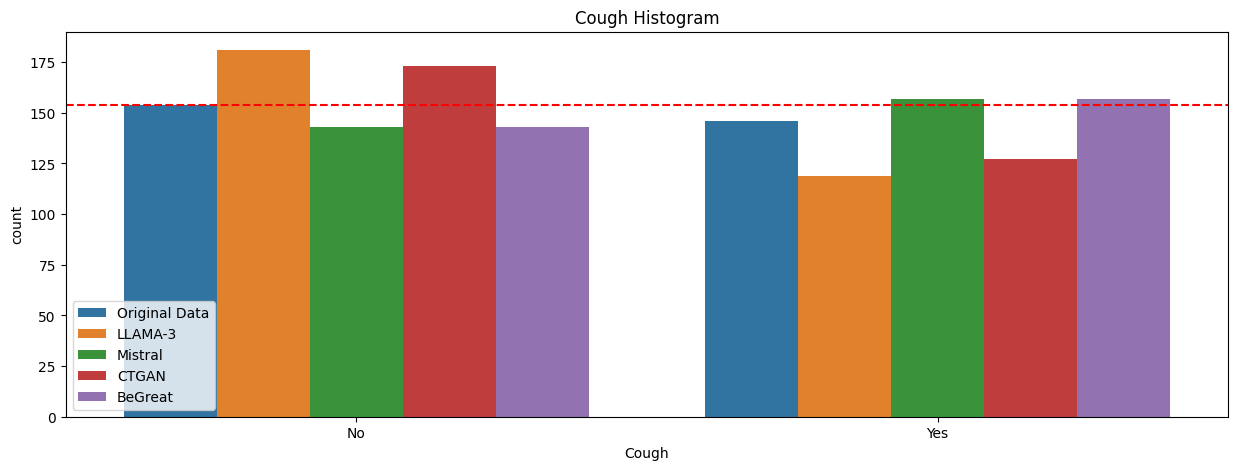

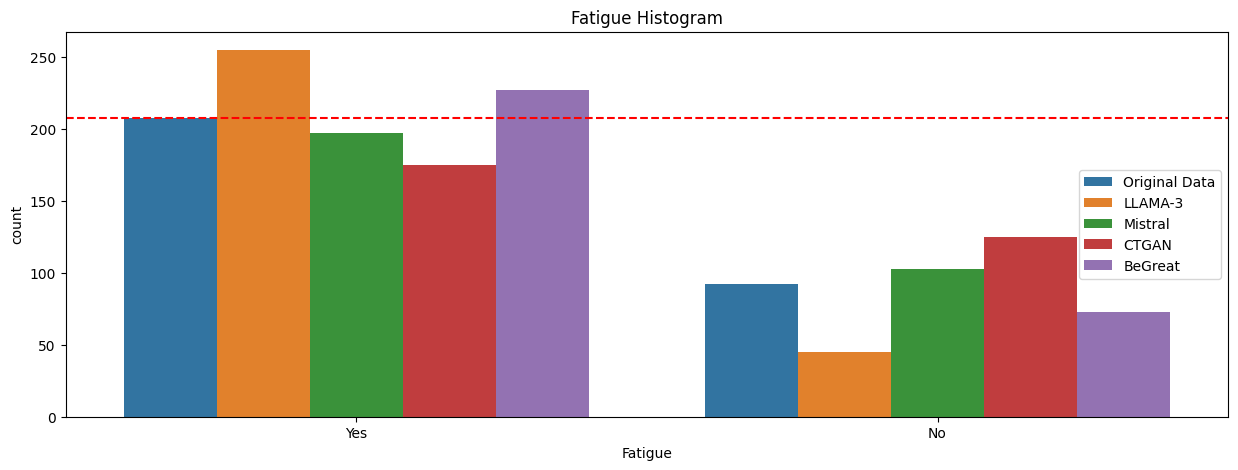

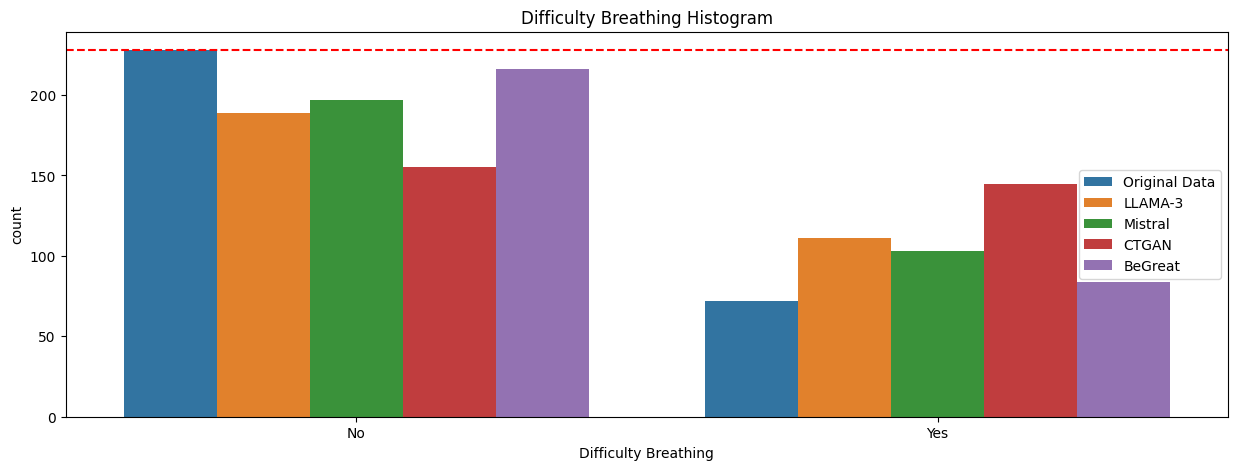

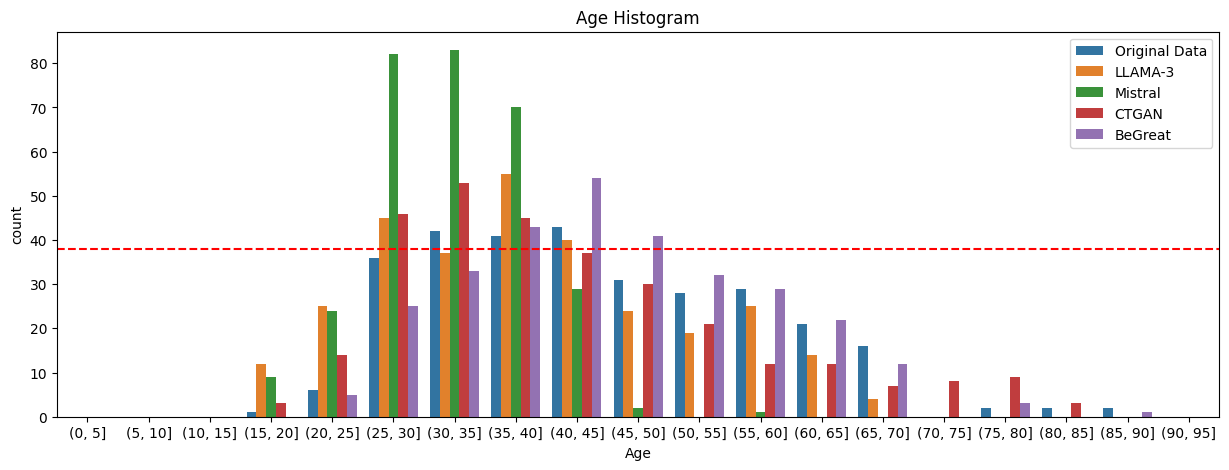

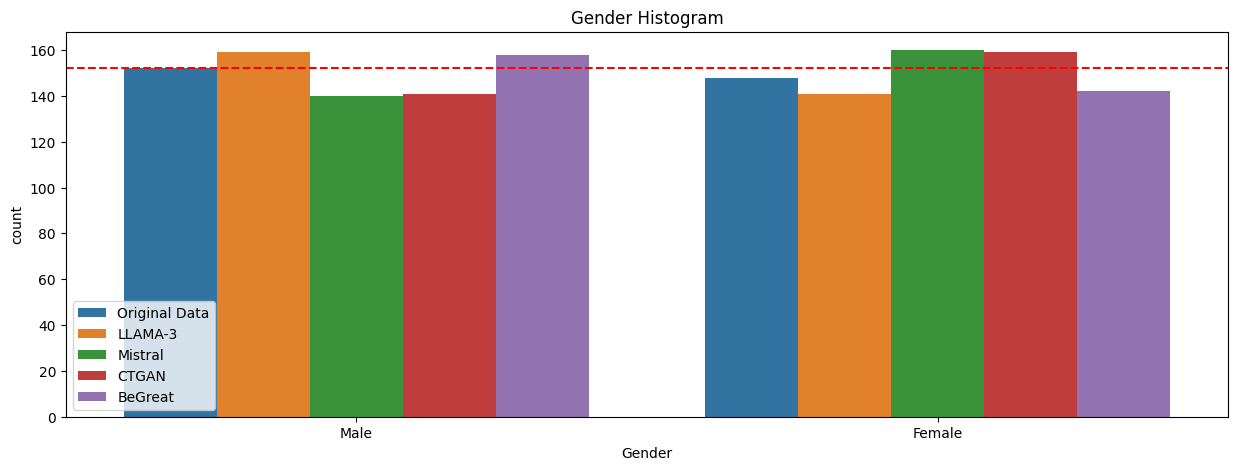

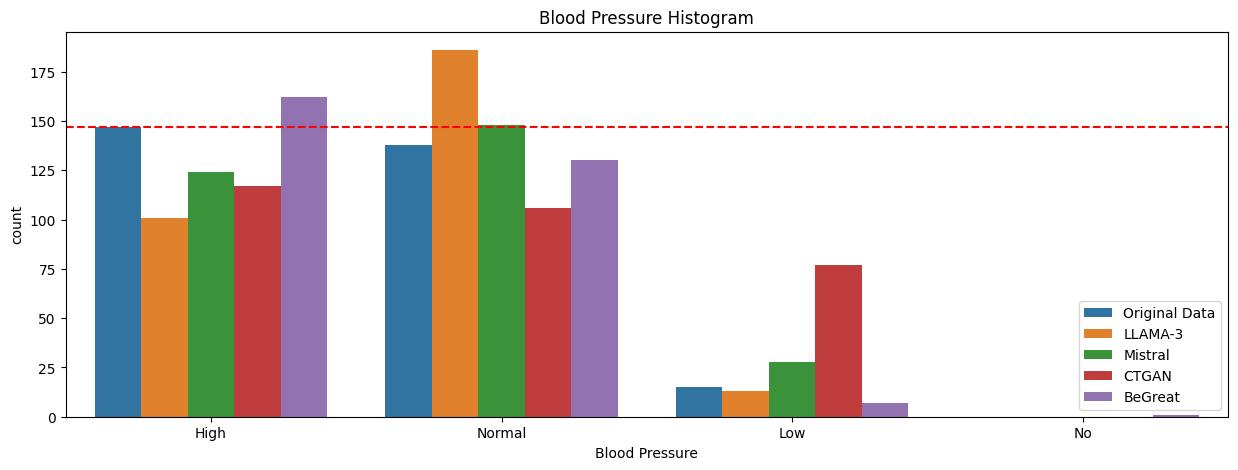

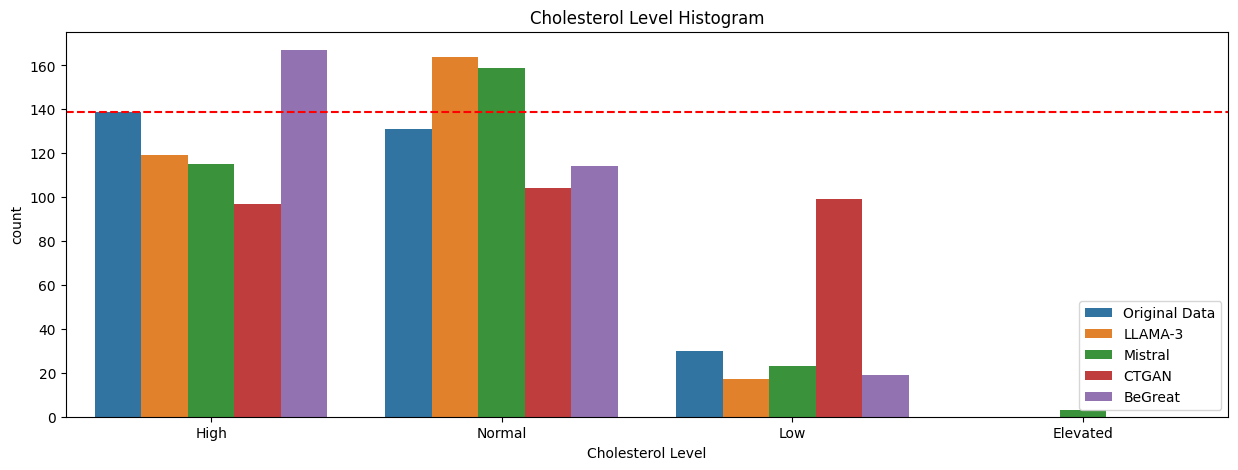

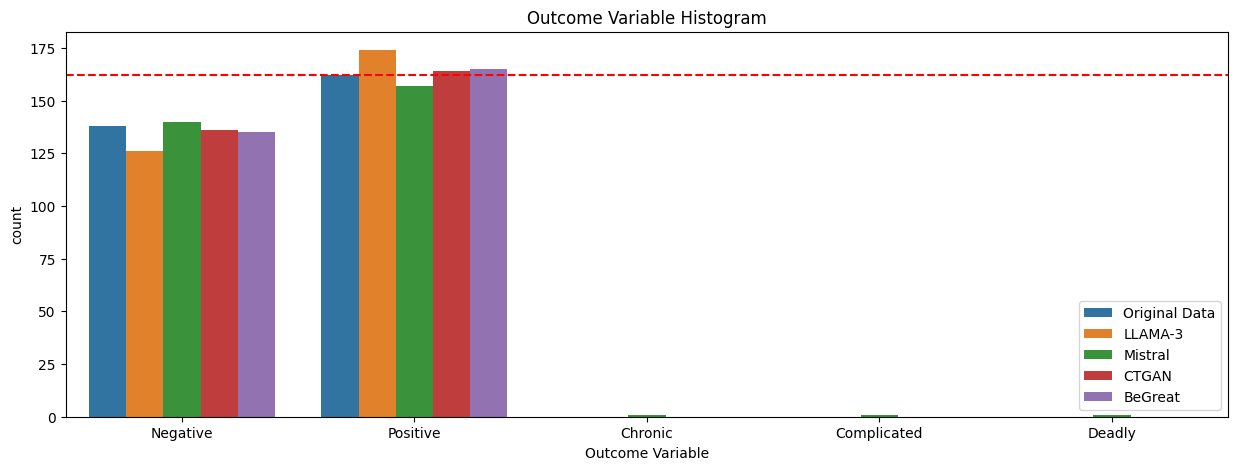

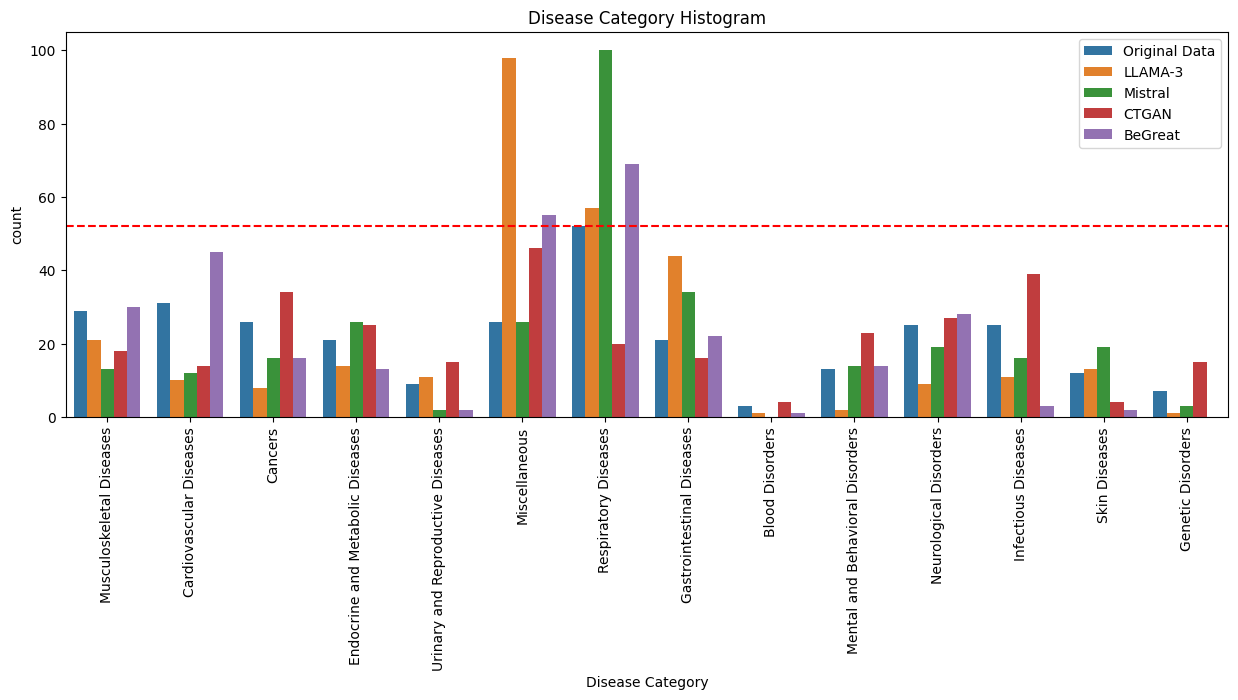

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataframes to long format for easier plotting
original_data['Source'] = 'Original Data'
generated_data_llama3['Source'] = 'LLAMA-3'
generated_data_mistral['Source'] = 'Mistral'
generated_data_ctgan['Source'] = 'CTGAN'
generated_data_begreat['Source'] = 'BeGreat'

# Concatenate all dataframes
all_data = pd.concat([original_data, generated_data_llama3, generated_data_mistral, generated_data_ctgan, generated_data_begreat])

for col in original_data.columns:
    if col == 'Disease' or col == 'Source':
        continue

    plt.figure(figsize=(15, 5))

    if col == 'Age':
        bins = np.arange(0, 100, 5)
        all_data[col] = pd.cut(all_data[col], bins=bins)

    if col == 'Disease Category':
        plt.xticks(rotation=90)
        
    sns.countplot(data=all_data, x=col, hue='Source')

    # Draw a horizontal line at the max value of original data
    max_val = original_data[col].value_counts().max()
    plt.axhline(y=max_val, color='r', linestyle='--')

    plt.title(f'{col} Histogram')
    plt.legend()
    plt.show()

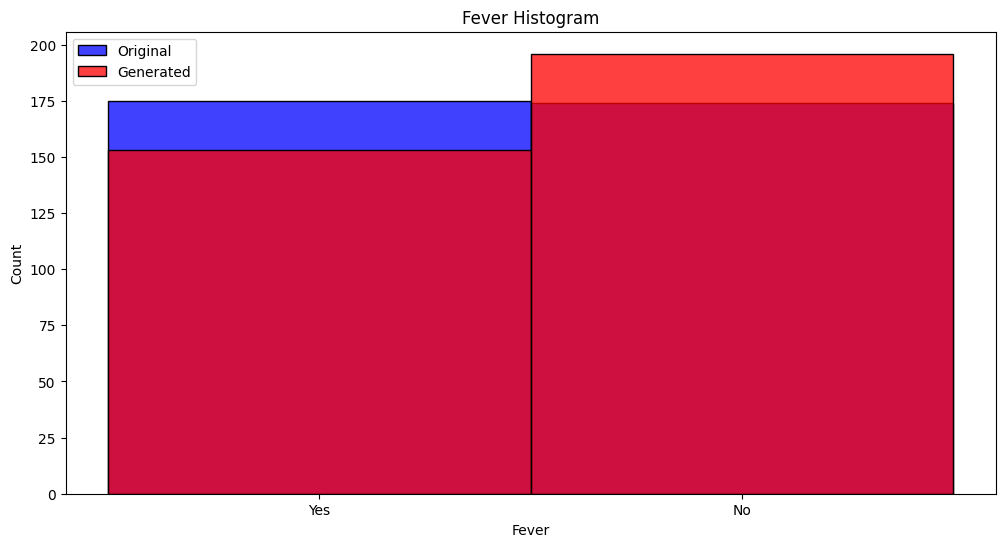

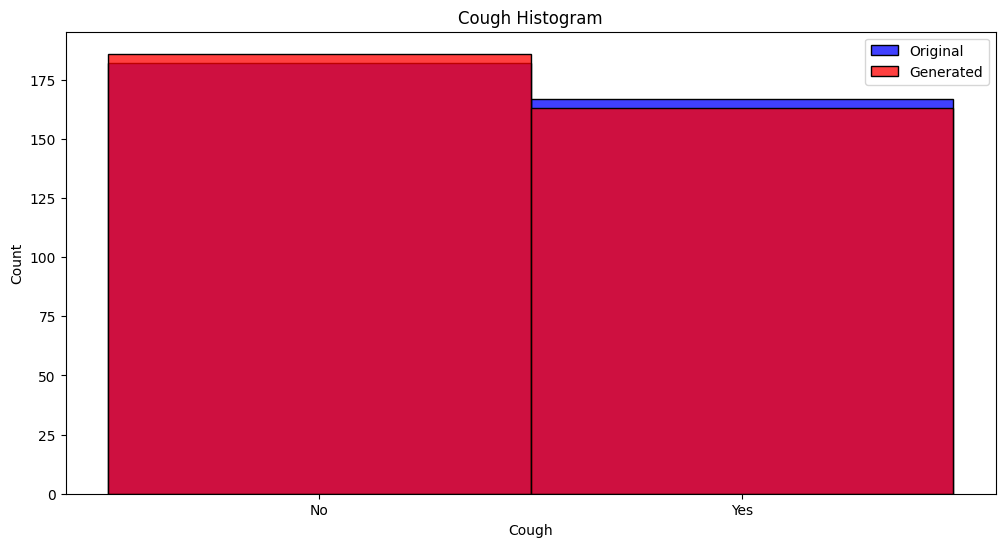

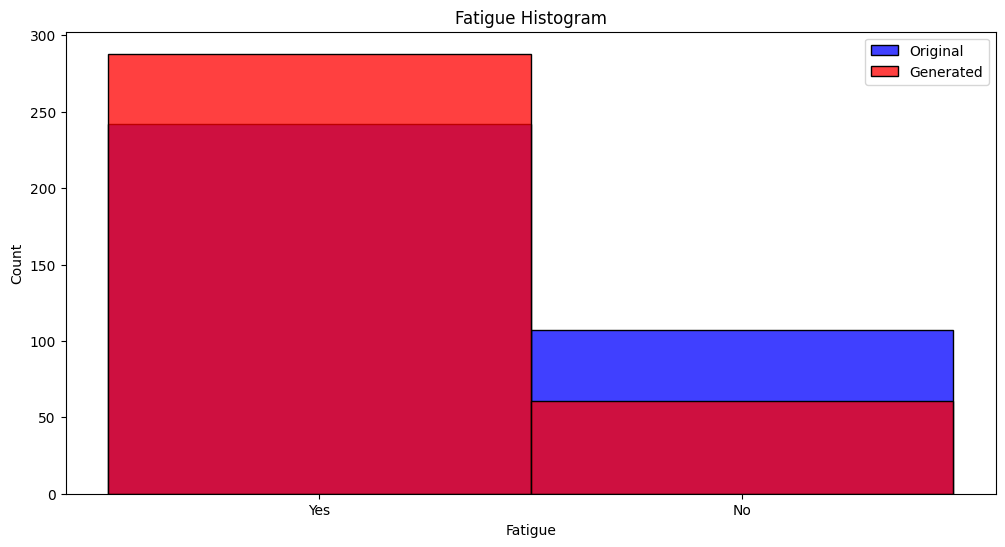

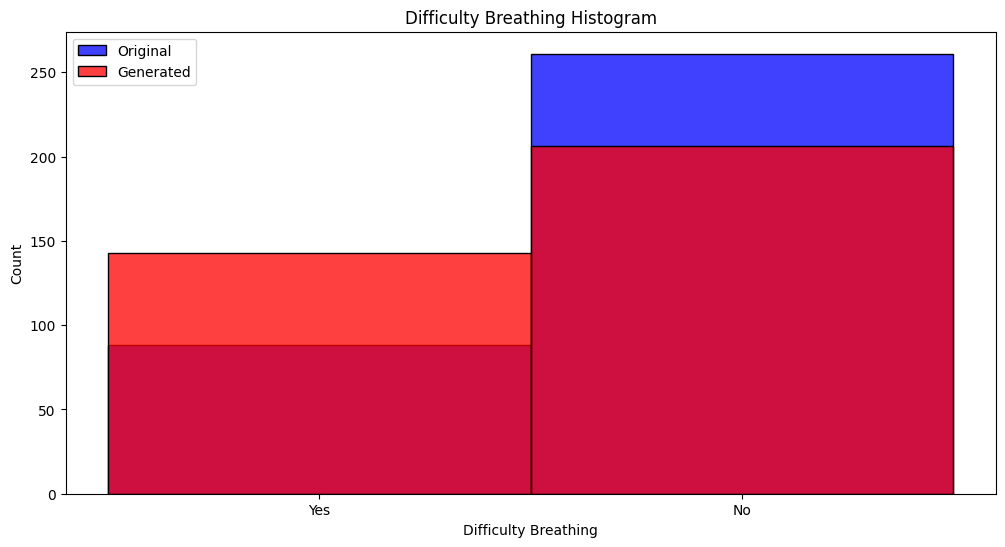

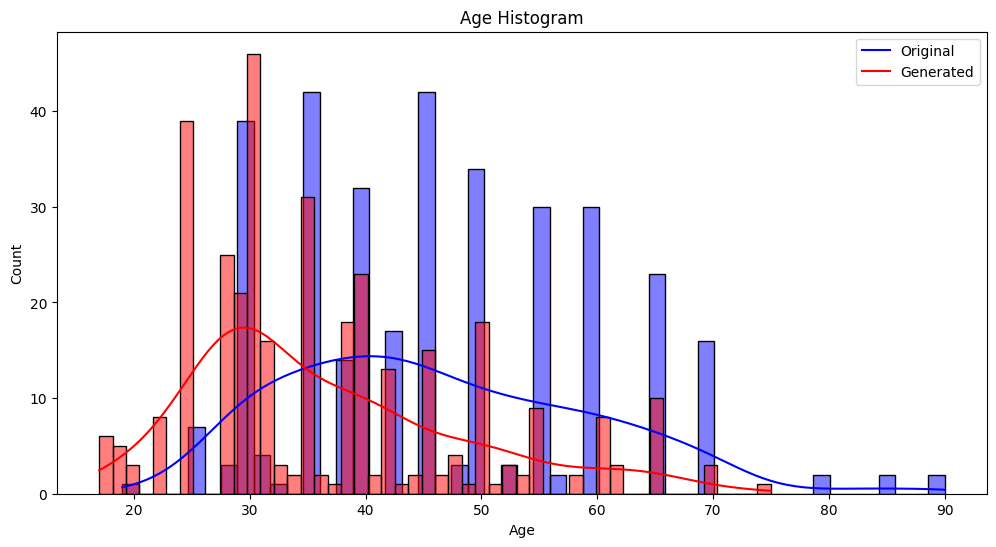

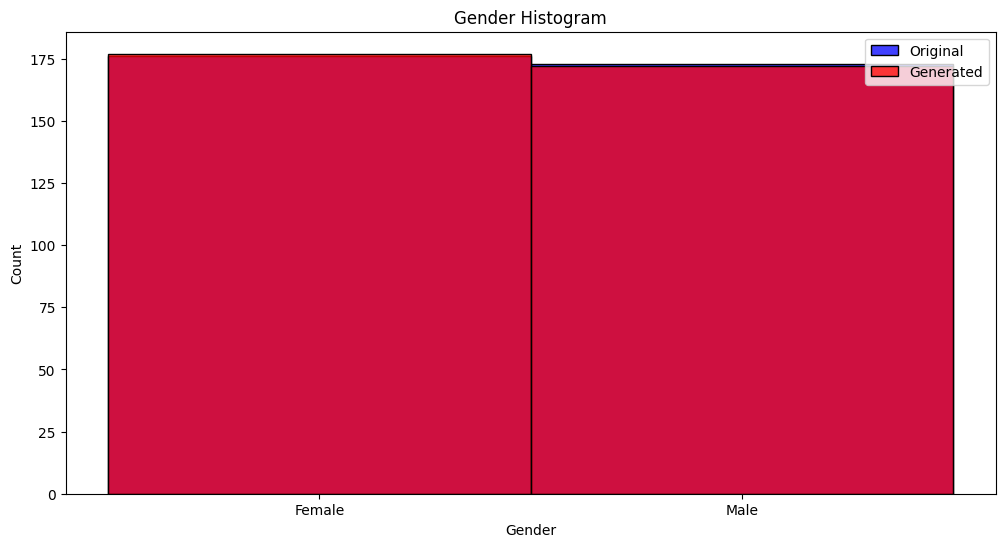

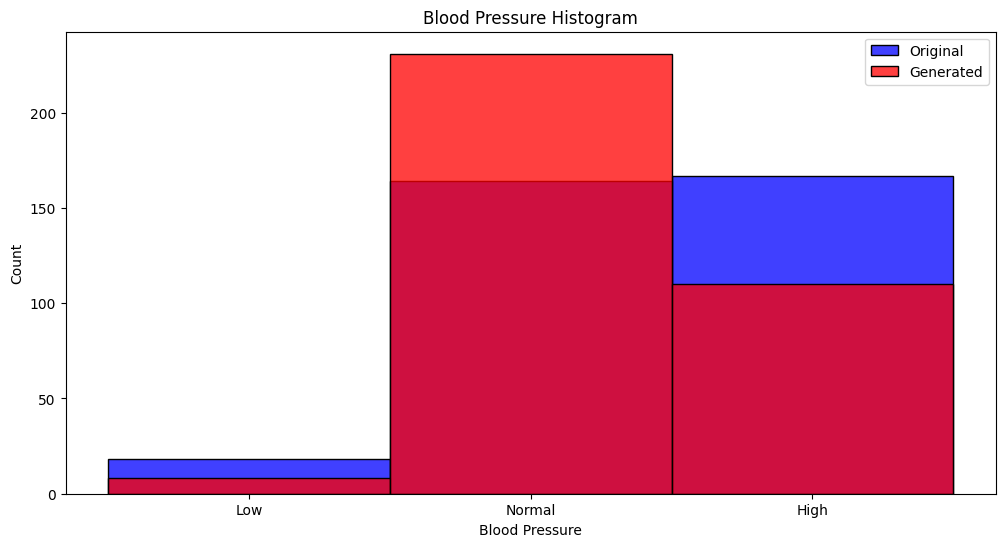

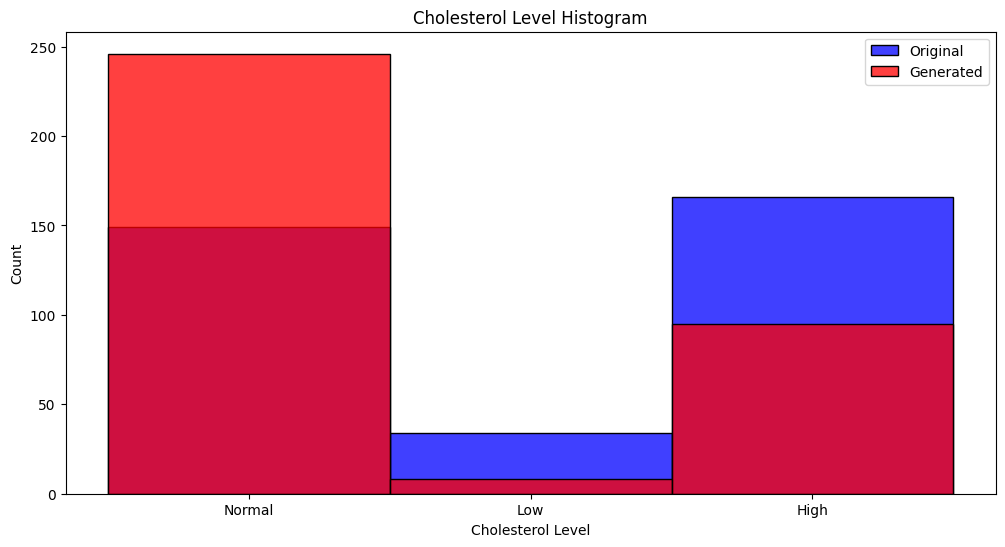

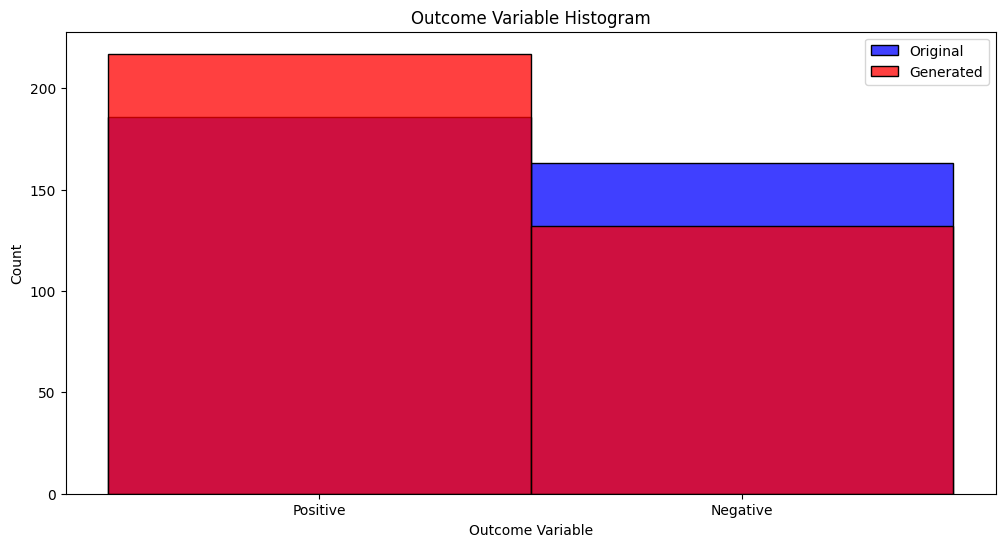

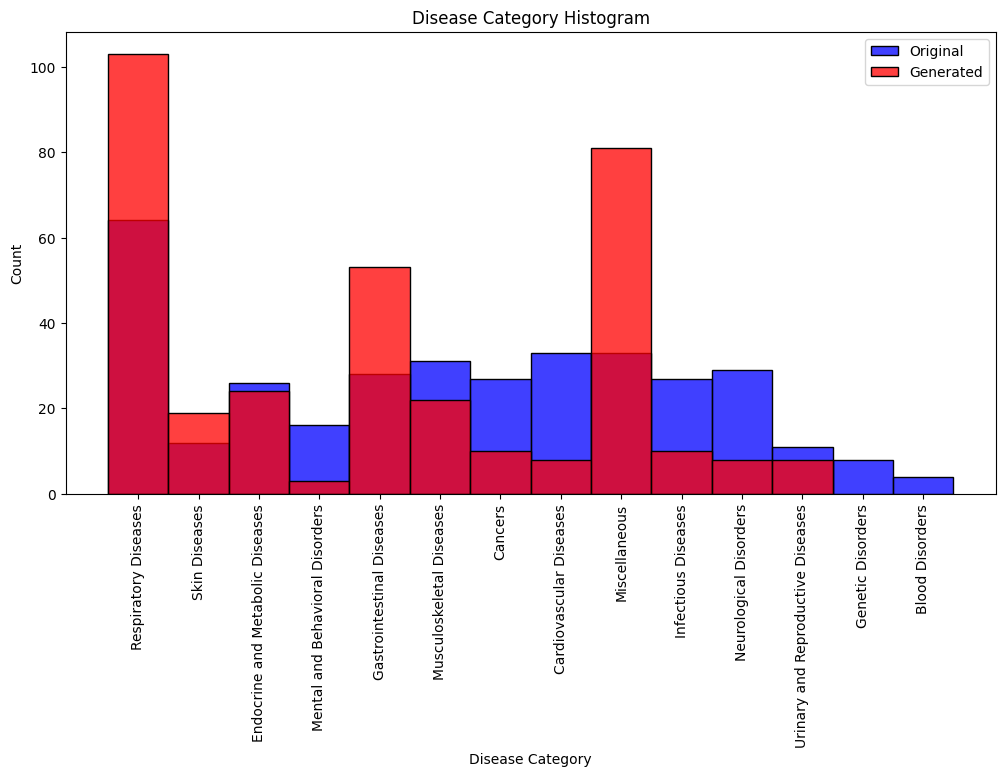

In [43]:
# Plot histograms
for col in original_data.columns:
    # Don't use the 'Disease' column for the histogram instead use the 'Disease Category' column
    if col == 'Disease':
        continue
    plt.figure(figsize=(12, 6))
    if col == 'Age':
        sns.histplot(original_data[col], color='blue', bins=50, kde=True)
        sns.histplot(generated_data[col], color='red', bins=50, kde=True)
    else:
        sns.histplot(original_data[col], color='blue', kde=False)
        sns.histplot(generated_data[col], color='red', kde=False)
    plt.title(f'{col} Histogram')
    plt.legend(['Original', 'Generated'])

    if col == 'Disease Category':
        plt.xticks(rotation=90)
    plt.show()


## Check if the distributions of the original and generated data are the same

In [44]:
# Check if the distributions of the original and generated data are the same
for col in original_data.columns:

    print(f'Feature: {col}')
    ks_stat, p_val = ks_2samp(original_data[col], generated_data[col])
    print(f'KS Statistic: {ks_stat}, p-value: {p_val}')
    if p_val < 0.05:
        print(f'The distributions of the feature {col} are different')
    else:
        print(f'The distributions of the feature {col} are the same')
    print()

Feature: Disease
KS Statistic: 0.0830945558739255, p-value: 0.17967286200122262
The distributions of the feature Disease are the same

Feature: Fever
KS Statistic: 0.06303724928366762, p-value: 0.4925357877061418
The distributions of the feature Fever are the same

Feature: Cough
KS Statistic: 0.011461318051575931, p-value: 1.0
The distributions of the feature Cough are the same

Feature: Fatigue
KS Statistic: 0.1318051575931232, p-value: 0.004613289387485903
The distributions of the feature Fatigue are different

Feature: Difficulty Breathing
KS Statistic: 0.15759312320916904, p-value: 0.00033608347919553334
The distributions of the feature Difficulty Breathing are different

Feature: Age
KS Statistic: 0.34097421203438394, p-value: 2.226013468246401e-18
The distributions of the feature Age are different

Feature: Gender
KS Statistic: 0.0028653295128939827, p-value: 1.0
The distributions of the feature Gender are the same

Feature: Blood Pressure
KS Statistic: 0.19197707736389685, p-va

/users/pgrad/mamu/Documents/first/.venv/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


### TODO: Check again the code below

In [45]:
# Categorical distribution comparison

# Create a new column 'Disease Category' in both datasets
original_data['Disease Category'] = original_data['Disease'].apply(classify_disease)
generated_data['Disease Category'] = generated_data['Disease'].apply(classify_disease)

# Check if the distributions of the original and generated data are the same
print('Disease Category Distribution Comparison:')
print(original_data['Disease Category'].value_counts())
print("\n")
print(generated_data['Disease Category'].value_counts())


Disease Category Distribution Comparison:
Disease Category
Respiratory Diseases                 64
Cardiovascular Diseases              33
Miscellaneous                        33
Musculoskeletal Diseases             31
Neurological Disorders               29
Gastrointestinal Diseases            28
Cancers                              27
Infectious Diseases                  27
Endocrine and Metabolic Diseases     26
Mental and Behavioral Disorders      16
Skin Diseases                        12
Urinary and Reproductive Diseases    11
Genetic Disorders                     8
Blood Disorders                       4
Name: count, dtype: int64


Disease Category
Respiratory Diseases                 103
Miscellaneous                         81
Gastrointestinal Diseases             53
Endocrine and Metabolic Diseases      24
Musculoskeletal Diseases              22
Skin Diseases                         19
Infectious Diseases                   10
Cancers                               10
Neurolog

KS Statistic: 0.17478510028653296, p-value: 4.50288652300715e-05
The distributions of the Disease Category are different
Chi-square Statistic: 156.16537019802917, p-value: 0.2133239942303504
The distributions of the Disease Category are the same


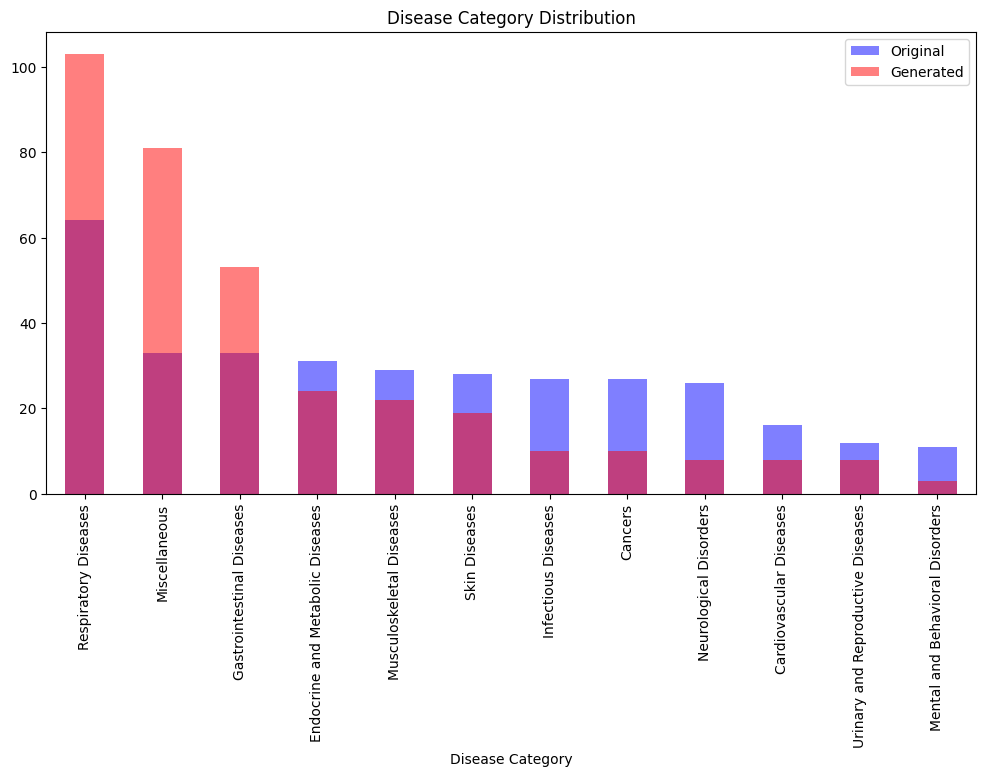

In [46]:
# Kolmogorov-Smirnov test for categorical data
ks_stat, p_val = ks_2samp(original_data['Disease Category'], generated_data['Disease Category'])
print(f'KS Statistic: {ks_stat}, p-value: {p_val}')
if p_val < 0.05:
    print('The distributions of the Disease Category are different')
else:
    print('The distributions of the Disease Category are the same')

# Chi-square test for categorical data
contingency_table = pd.crosstab(original_data['Disease Category'], generated_data['Disease Category'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-square Statistic: {chi2}, p-value: {p}')
if p < 0.05:
    print('The distributions of the Disease Category are different')
else:
    print('The distributions of the Disease Category are the same')

# Plot the distribution of the Disease Category bars side by side
plt.figure(figsize=(12, 6))
original_data['Disease Category'].value_counts().plot(kind='bar', color='blue', alpha=0.5)
generated_data['Disease Category'].value_counts().plot(kind='bar', color='red', alpha=0.5)
plt.title('Disease Category Distribution')
plt.legend(['Original', 'Generated'])
plt.xticks(rotation=90)
plt.show()


## Correlation comparison


### One-hot encode the 'Disease Category' column


In [47]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'Disease Category' column
encoder = OneHotEncoder()
original_encoded = encoder.fit_transform(original_data[['Disease Category']])
generated_encoded = encoder.transform(generated_data[['Disease Category']])

### Calculate the cosine similarity between the one-hot encoded 'Disease Category' columns


In [48]:
# Calculate the cosine similarity between the one-hot encoded 'Disease Category' columns
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(original_encoded, generated_encoded)
print(f'Cosine Similarity: {cosine_sim.mean()}')

Cosine Similarity: 0.11046707334094137


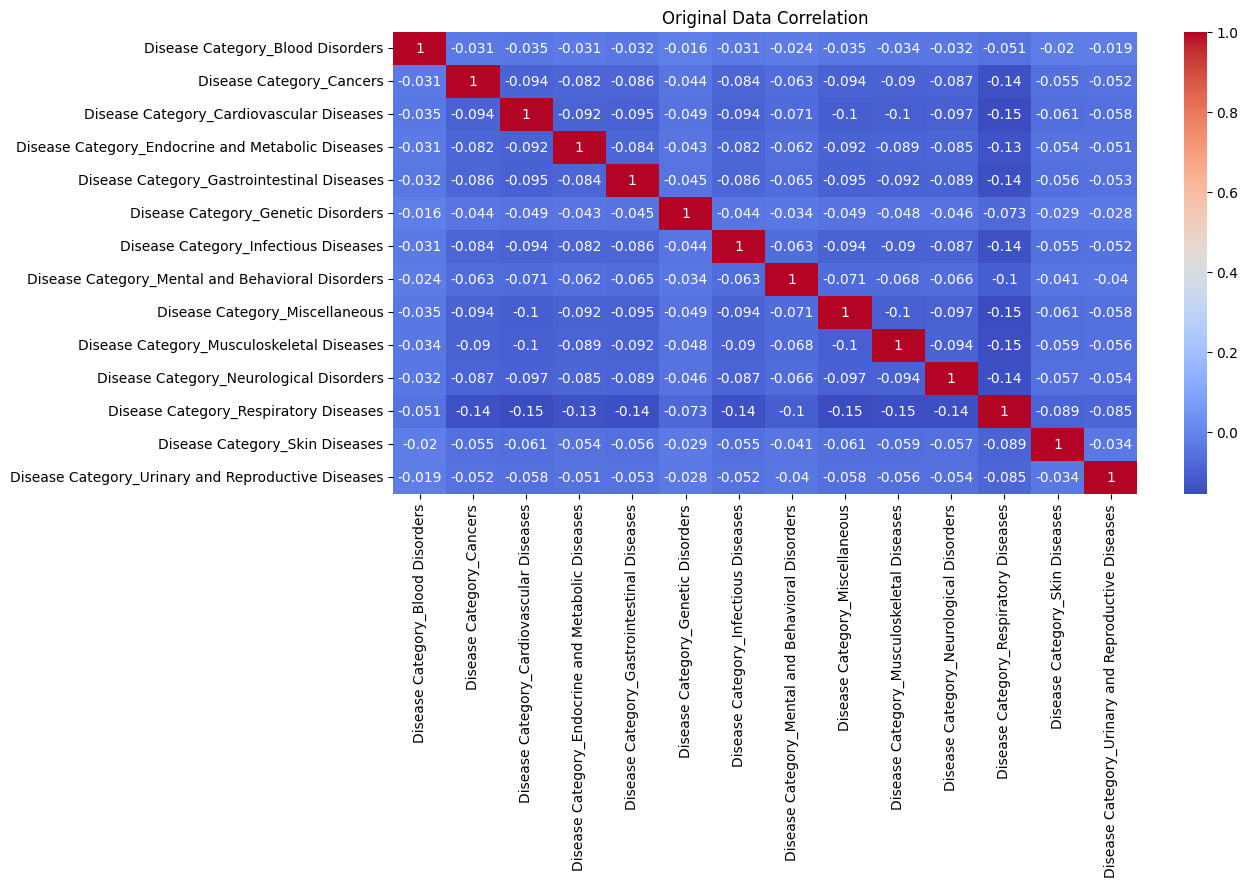

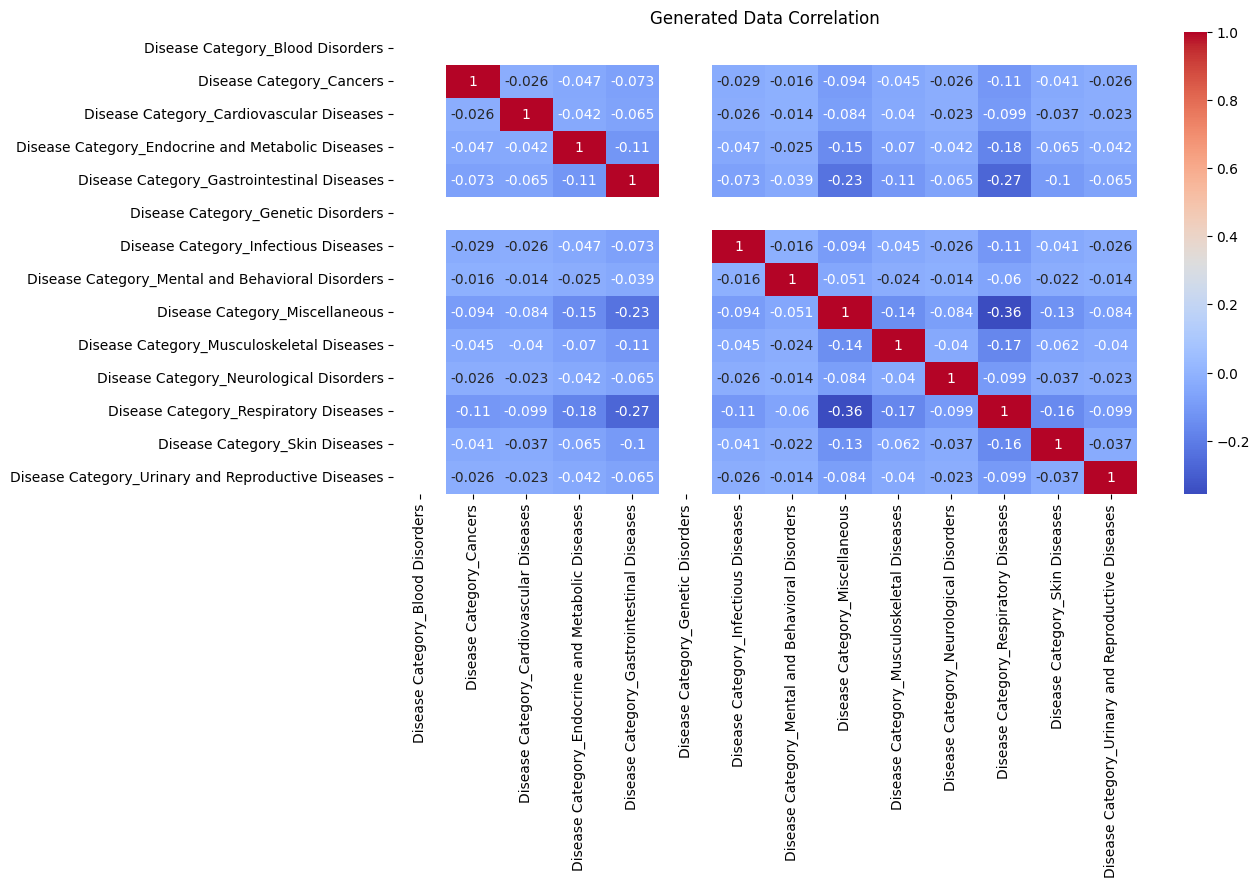

KS Statistic: nan, p-value: nan
The correlation matrices are the same
Chi-square Statistic: 89.4227524487581, p-value: 0.999999925216575
The correlation matrices are the same


In [49]:
# Combine unique disease categories from both datasets
all_disease_categories = np.unique(np.concatenate((original_data['Disease Category'].unique(), generated_data['Disease Category'].unique())))

# One-hot encoding the combined disease categories
encoder = OneHotEncoder(categories=[all_disease_categories])
original_encoded = encoder.fit_transform(original_data[['Disease Category']]).toarray()
generated_encoded = encoder.transform(generated_data[['Disease Category']]).toarray()

# Creating DataFrames from the encoded data
original_encoded_df = pd.DataFrame(original_encoded, columns=encoder.get_feature_names_out(['Disease Category']))
generated_encoded_df = pd.DataFrame(generated_encoded, columns=encoder.get_feature_names_out(['Disease Category']))

# Calculate correlation matrices
original_corr = original_encoded_df.corr()
generated_corr = generated_encoded_df.corr()

# Plot correlation matrices
plt.figure(figsize=(12, 6))
sns.heatmap(original_corr, annot=True, cmap='coolwarm')
plt.title('Original Data Correlation')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(generated_corr, annot=True, cmap='coolwarm')
plt.title('Generated Data Correlation')
plt.show()

# Check if the correlation matrices are the same using KS test
ks_stat, p_val = ks_2samp(original_corr.values.flatten(), generated_corr.values.flatten())
print(f'KS Statistic: {ks_stat}, p-value: {p_val}')
if p_val < 0.05:
    print('The correlation matrices are different')
else:
    print('The correlation matrices are the same')

# Check if the correlation matrices are the same using Chi-square test
chi2, p, dof, expected = chi2_contingency(np.abs(original_corr.values))
print(f'Chi-square Statistic: {chi2}, p-value: {p}')
if p < 0.05:
    print('The correlation matrices are different')
else:
    print('The correlation matrices are the same')

In [50]:
# One-hot encode the 'Disease Category' column
encoder = OneHotEncoder()
original_encoded = encoder.fit_transform(original_data[['Disease Category']])
generated_encoded = encoder.transform(generated_data[['Disease Category']])
original_encoded_df = pd.DataFrame(original_encoded.toarray(), columns=encoder.get_feature_names_out(['Disease Category']))
generated_encoded_df = pd.DataFrame(generated_encoded.toarray(), columns=encoder.get_feature_names_out(['Disease Category']))

# Drop the 'Disease Category' column from the original data
original_data = original_data.drop(columns=['Disease Category', 'Disease'])
generated_data = generated_data.drop(columns=['Disease Category', 'Disease'])

# Join the original data with the one-hot encoded data
original_data_encoded = original_data.join(original_encoded_df)
generated_data_encoded = generated_data.join(generated_encoded_df)

# Calculate the correlation
original_corr = original_data_encoded.corr()
generated_corr = generated_data_encoded.corr()

# Select the correlations with the one-hot encoded 'Disease Category' columns
original_corr = original_corr.loc[:, original_encoded_df.columns]
generated_corr = generated_corr.loc[:, generated_encoded_df.columns]

# Plot the correlation
plt.figure(figsize=(12, 6))
original_corr.mean().plot(kind='bar', color='blue', alpha=0.5)
generated_corr.mean().plot(kind='bar', color='red', alpha=0.5)
plt.title('Correlation with Disease Category')
plt.legend(['Original', 'Generated'])
plt.xticks(rotation=90)
plt.show()

ValueError: could not convert string to float: 'Yes'

### Count of diseases between the two datasets

Original Disease Counts: {'Respiratory Diseases': 501, 'Skin Diseases': 93, 'Endocrine and Metabolic Diseases': 150, 'Mental and Behavioral Disorders': 57, 'Cardiovascular Diseases': 123, 'Gastrointestinal Diseases': 243, 'Cancers': 111, 'Neurological Disorders': 111, 'Musculoskeletal Diseases': 159, 'Infectious Diseases': 111, 'Urinary and Reproductive Diseases': 57, 'Blood Disorders': 12, 'Genetic Disorders': 24, 'Miscellaneous': 18}


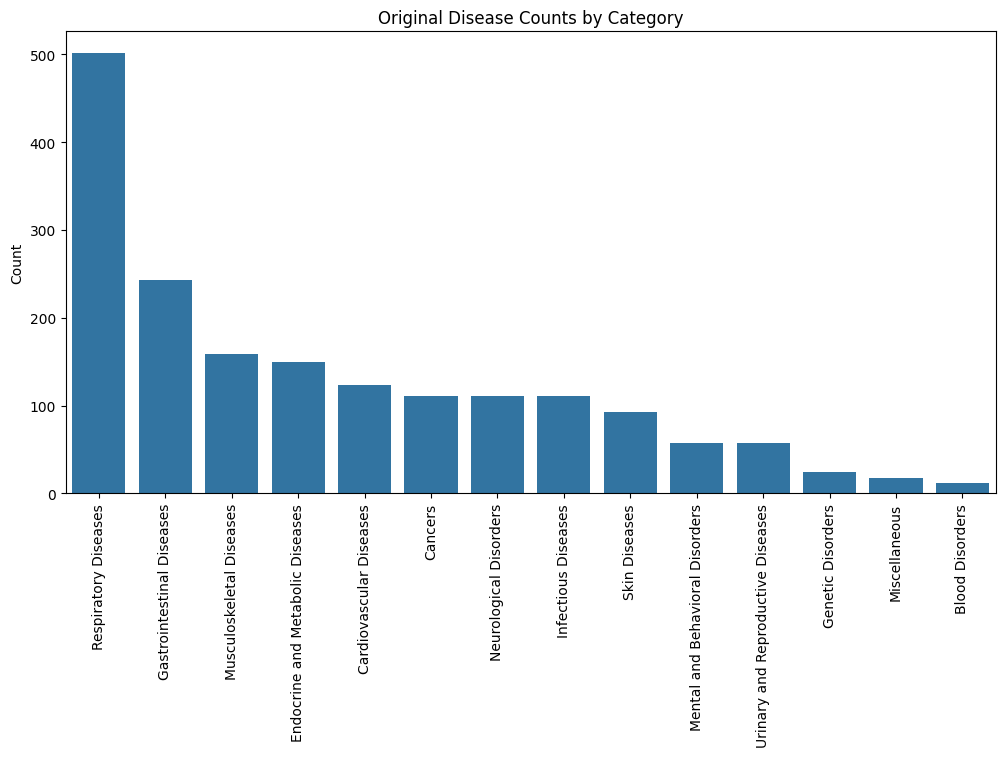

In [ ]:
# Classify the diseases in the original dataset
original_data['Disease Category'] = original_data['Disease'].apply(classify_disease)

# Classify the diseases in the generated dataset
generated_data['Disease Category'] = generated_data['Disease'].apply(classify_disease)

# Print the counts of diseases in each category
print('Original Disease Counts:', categories_count)

# Plot the counts of diseases in each category and order by number of counts
plt.figure(figsize=(12, 6))
sns.barplot(x=list(categories_count.keys()), y=list(categories_count.values()), order=sorted(categories_count, key=categories_count.get, reverse=True))
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.title('Original Disease Counts by Category')
plt.show()


### Calculate the chi-square statistic and p-value for the disease categories


In [ ]:
# Calculate the chi-square statistic and p-value for the disease categories
chi2_stat, p_val, _, _ = chi2_contingency(
    pd.crosstab(original_data['Disease Category'], generated_data['Disease Category'])
)

# Print the chi-square statistic and p-value
print('Chi-Square Statistic:', chi2_stat)
print('P-Value:', p_val)

Chi-Square Statistic: 156.16537019802917
P-Value: 0.2133239942303504


### Calculate the Kolmogorov-Smirnov statistic and p-value for the disease categories


KS Statistic: 0.39285714285714285
P-Value: 0.2058202263478882


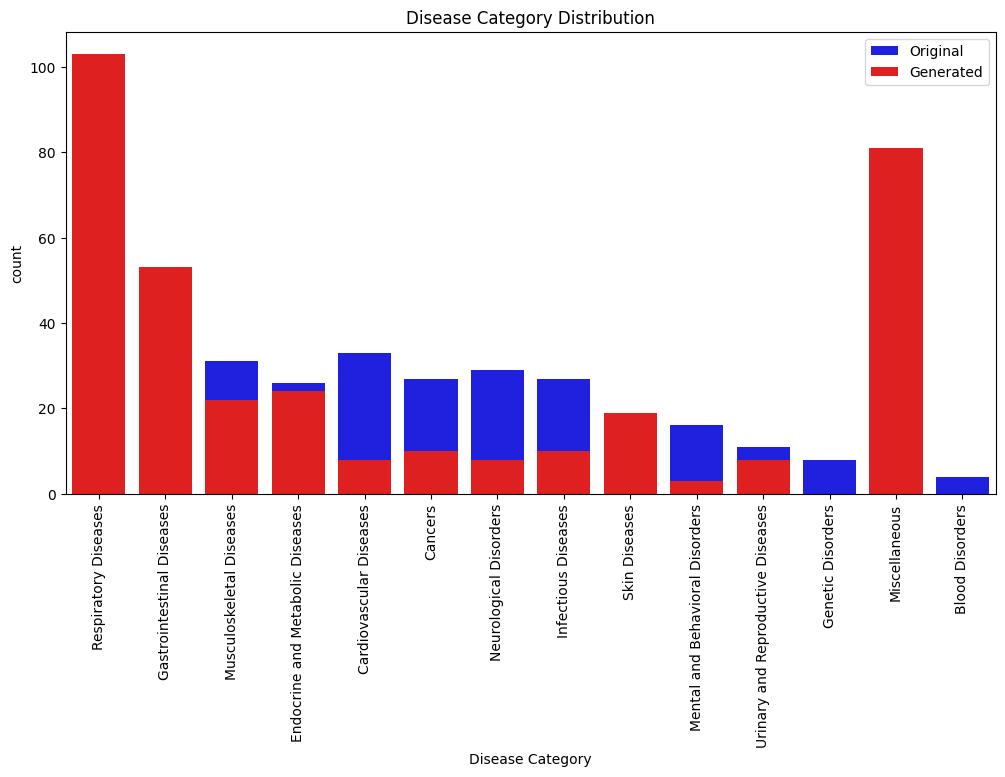

In [ ]:
# Calculate the Kolmogorov-Smirnov statistic and p-value for the disease categories

ks_stat, p_val = ks_2samp(
    original_data['Disease Category'].value_counts(normalize=True),
    generated_data['Disease Category'].value_counts(normalize=True)
)

# Print the Kolmogorov-Smirnov statistic and p-value
print('KS Statistic:', ks_stat)
print('P-Value:', p_val)

# Plot the distribution of disease categories in the original and generated datasets and order by number of counts
plt.figure(figsize=(12, 6))
sns.countplot(x='Disease Category', data=original_data, color='blue', order=sorted(categories_count, key=categories_count.get, reverse=True))
sns.countplot(x='Disease Category', data=generated_data, color='red', order=sorted(categories_count, key=categories_count.get, reverse=True))
plt.xticks(rotation=90)
plt.title('Disease Category Distribution')
plt.legend(['Original', 'Generated'])
plt.show()

# Dimensionality Reduction and Visualization


## T-SNE Visualisation

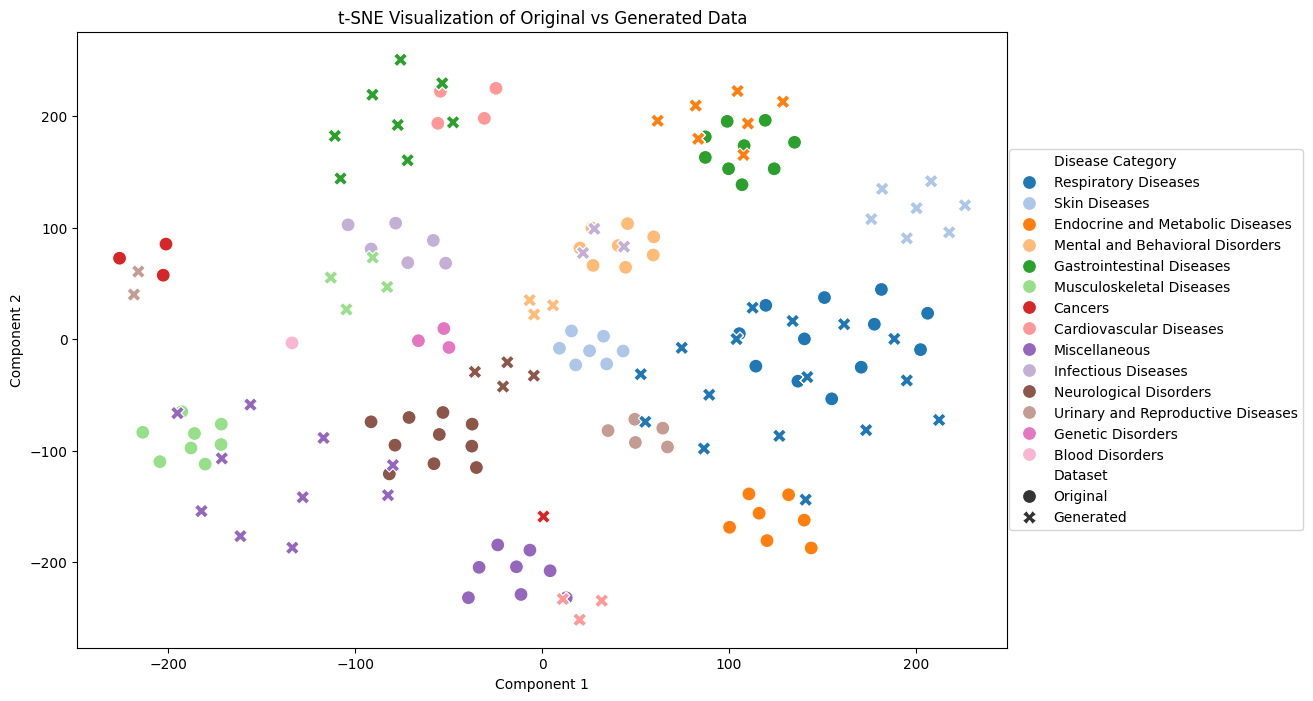

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder

# Assuming original_data and generated_data are your datasets

# One-hot encode the 'Disease Category' column
encoder = OneHotEncoder()
original_encoded = encoder.fit_transform(original_data[['Disease Category']])
generated_encoded = encoder.transform(generated_data[['Disease Category']])
original_encoded = original_encoded.toarray()
generated_encoded = generated_encoded.toarray()

# Perform t-SNE on the one-hot encoded data
tsne = TSNE(n_components=2, random_state=42)
original_tsne = tsne.fit_transform(original_encoded)
generated_tsne = tsne.fit_transform(generated_encoded)

# Create a combined DataFrame for easier plotting
import pandas as pd
original_df = pd.DataFrame(original_tsne, columns=['Component 1', 'Component 2'])
original_df['Dataset'] = 'Original'
original_df['Disease Category'] = original_data['Disease Category']

generated_df = pd.DataFrame(generated_tsne, columns=['Component 1', 'Component 2'])
generated_df['Dataset'] = 'Generated'
generated_df['Disease Category'] = generated_data['Disease Category']

combined_df = pd.concat([original_df, generated_df])

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Disease Category', style='Dataset', palette='tab20', data=combined_df, markers=True, s=100)
plt.title('t-SNE Visualization of Original vs Generated Data')
# make the legend smaller
plt.legend(loc='center', bbox_to_anchor=(1.16, 0.5), ncol=1)
plt.show()


## PCA

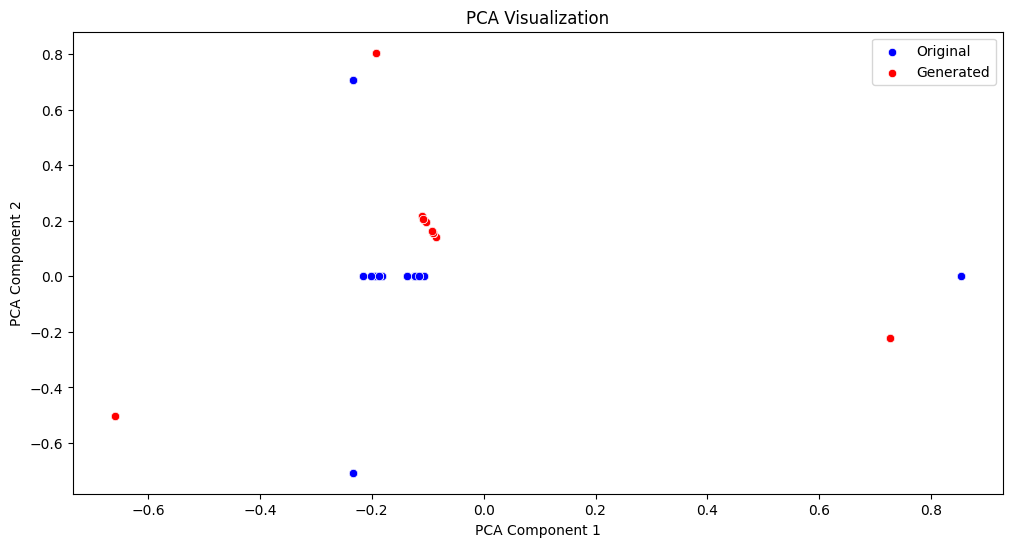

In [ ]:
# Principal Component Analysis (PCA) Visualisation
from sklearn.decomposition import PCA

# Perform PCA on the one-hot encoded data
pca = PCA(n_components=2)
original_pca = pca.fit_transform(original_encoded)
generated_pca = pca.fit_transform(generated_encoded)

# Plot the PCA visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(x=original_pca[:, 0], y=original_pca[:, 1], color='blue')
sns.scatterplot(x=generated_pca[:, 0], y=generated_pca[:, 1], color='red')
plt.title('PCA Visualization')
plt.legend(['Original', 'Generated'])
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

